In [1]:
#packages import
import os
os.chdir('..') #cd to PiperNET folder

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

#matplotlib settings
plt.style.use('classic')
plt.rcParams['figure.facecolor'] = 'white'

### Data import

In [2]:
from src.import_utils import get_config
from src.import_utils import import_sonicpd

config_path = Path('config/rnaseq_dataprep.yaml')
proteomes_all = pd.read_csv('data/rna-seq/proteomes_all.csv', index_col='id') #merged proteome file
sonicpd = import_sonicpd(get_config(config_path, data='orthogroups', file='sonicparanoid'))
blastDBs = get_config(Path('config/rnaseq_dataprep.yaml'), data='blastDB') #BLAST databases paths
enzymeDB = pd.read_csv('data/rna-seq/enzymeDB.csv')
seq_paths = get_config(config_path, data='enzymeDB') #sequences paths
prefixes = get_config(config_path, data='prefix', filepaths=False)
species_names = get_config(config_path, data='species', filepaths=False)
legend = get_config(config_path, data='colors', filepaths=False) #colors legend

### BLASTp P. nigrum sequences
BLASTp all characterized enzymes in the piperine biosynthetic pathway against all transcriptomes:
- PnBAHD1 (BAHD acyltransferase)
- PnBAHD2 (BAHD acyltransferase)
- PnCYP719A37 (CYP450)
- PnPIPCoAL (Piperic acid-CoA-ligase)
- PnFDS1 (Feruloyldiketide-CoA synthases)
- PnFDS2 (Feruloyldiketide-CoA synthases)
- PnLDC (Lysine decarboxylase)
- PnCAO (Copper amine oxidase) 

In [3]:
from src.rnaseq_utils import run_blastp
pn_queries = {k: v for k, v in seq_paths.items() if 'Pn' in k} #keep only Pn sequences

#BLASTp all seqs vs all proteomes
out = Path('results/blast/pn_hits.csv')
if not os.path.isfile(out):

    #BLASTp pn_queries vs all proteomes
    hits_all = run_blastp(pn_queries, blastDBs, out_path=out, min_cov=50, min_sim=50, min_bitscore = 50, create_combinedID = False)

else:
    print(f"File {out} already exists. Importing existing file.")
    hits_all = pd.read_csv(out)

File results/blast/pn_hits.csv already exists. Importing existing file.


### Evaluate best hits in P. nigrum transcriptome (piper56)

In [4]:
#keep piper56 based on similarity
hits_p56 = hits_all[hits_all['sample'] == 'piper56'].sort_values(by='similarity', ascending=False).groupby('query').first()

print(f"""Hits have:
       - similarity between {hits_p56['similarity'].min()} and {hits_p56['similarity'].max()}
       - query coverage between {hits_p56['query coverage'].min()} and {hits_p56['query coverage'].max()}
       - BLAST bit score between {hits_p56['bit score'].min()} and {hits_p56['bit score'].max()}""")

Hits have:
       - similarity between 98.03 and 99.82
       - query coverage between 77 and 100
       - BLAST bit score between 2072 and 3895


Expression levels in different tissues

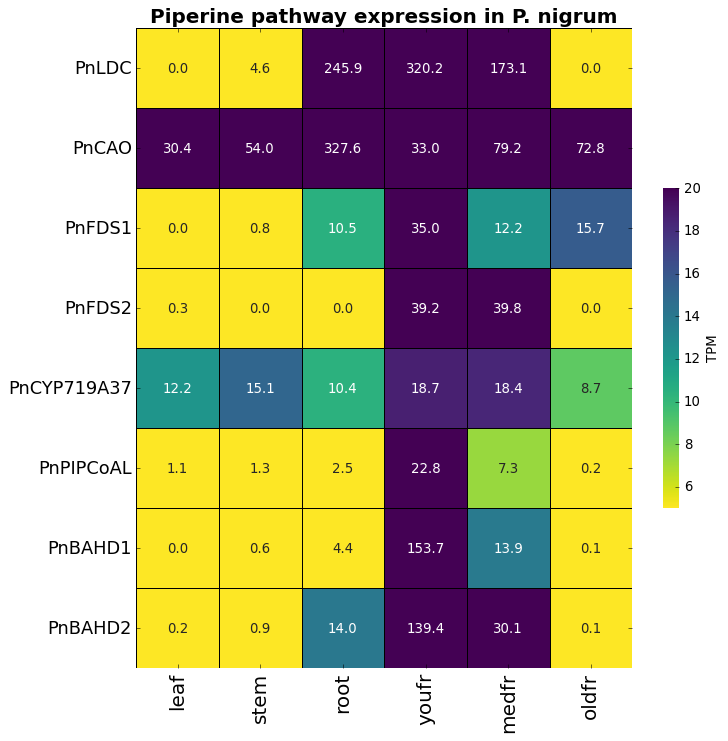

In [5]:
from src.rnaseq_utils import assign_tissue_expr
hits_p56_ids = hits_p56['hit']
data = assign_tissue_expr(proteomes_all.loc[hits_p56_ids], metric='mean')

#switch index in data with hits_p56.index
if (data.index == hits_p56['hit']).all(): #check if the id match
    data.index = hits_p56.index
    enzyme_order = ['PnLDC', 'PnCAO', 'PnFDS1', 'PnFDS2', 'PnCYP719A37', 'PnPIPCoAL', 'PnBAHD1', 'PnBAHD2']
    data = data.reindex(enzyme_order)

#plot heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(data, cmap='viridis_r', annot=True, fmt=".1f", yticklabels=True, vmin=5, vmax=20,
            linewidths=0.75, linecolor='black',
            cbar_kws={'label': 'TPM', 'orientation': 'vertical', 'pad': 0.05, 'shrink': 0.5})
plt.yticks(fontsize=16)
plt.xticks(fontsize=18, rotation=90)
plt.ylabel('')
plt.title('Piperine pathway expression in P. nigrum', fontdict={'fontsize': 18, 'fontweight': 'bold'})
plt.show()

### Evaluate best hits across all species

In [6]:
hits_best = hits_all.sort_values('similarity', ascending=False).groupby(['sample','query']).first() #keep best hit (similarity) for each query
sim_table = hits_best.reset_index().pivot(index='query', columns='sample', values='similarity').astype(float).rename(columns=species_names).reindex(enzyme_order)
cover_table = hits_best.reset_index().pivot(index='query', columns='sample', values='query coverage').astype(int).rename(columns=species_names).reindex(enzyme_order)
eval_matrix = hits_best.reset_index().pivot(index='query', columns='sample', values='e-value').rename(columns=species_names).reindex(enzyme_order)

Best hit similarity across species

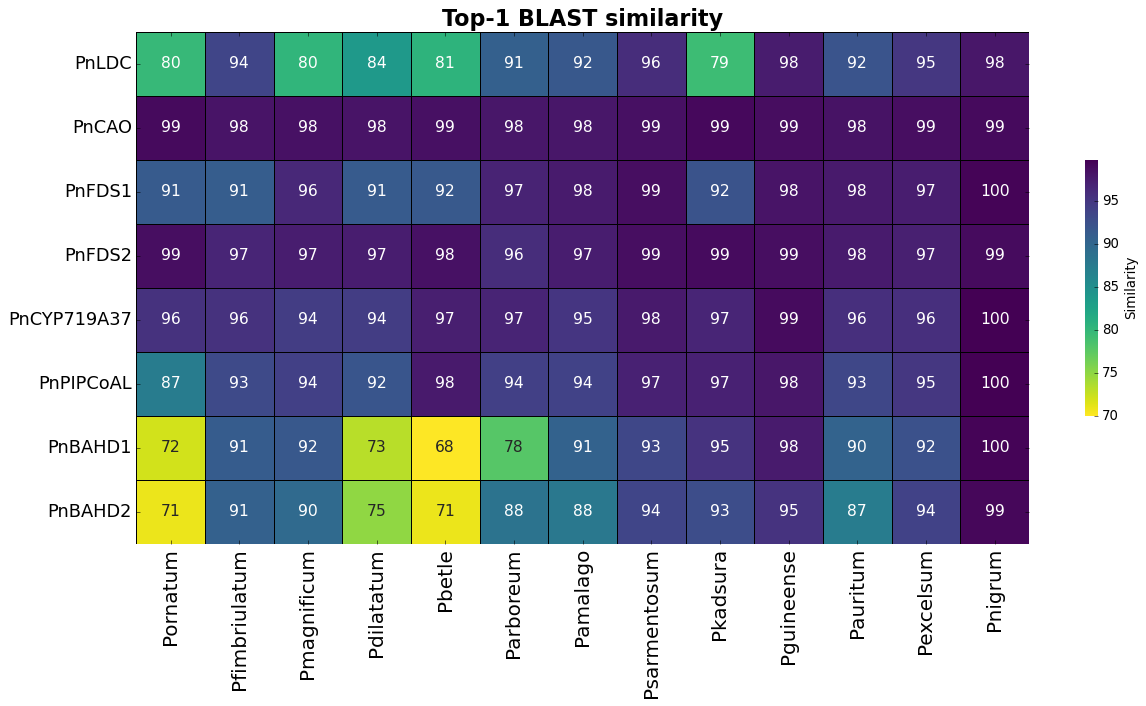

In [9]:
data = sim_table
# annotation = cover_table
# annotations.at[index, column] = ('sim='+str(top_sim)) + '\n' + ('cov='+str(top_cov)) + '\n' + ('len='+str(top_len)) + '\n' + (str(top_orf))

#heatmap
plt.figure(figsize=(18, 8))  # adjust the size of the plot as needed
sns.heatmap(data, cmap='viridis_r', vmin=70, annot=True, fmt='.0f', annot_kws={"fontsize":14},
            linewidths=0.75, linecolor='black',
            cbar_kws={'label': 'Similarity', 'orientation': 'vertical', 'pad': 0.05, 'shrink': 0.5})
plt.yticks(fontsize=16)
plt.xticks(fontsize=18, rotation=90)
plt.xlabel('')
plt.ylabel('')
plt.title('Top-1 BLAST similarity', fontsize=20, fontweight='bold')
plt.show()

### P. nigrum sequences in orthogroups
Orthogroups in `sonicpd` containting the best P. nigrum hits (`hits_p56`) are retrieved. Two heatmaps are built:
- Count-based: n° of genes per species in each orthogroup (`pks_orths_count`). This highlights the species involved in each orthogroup.
- Expression-based: max or mean expression of genes per species in each orthogroup (`pks_orths_expr`). This highlights expression levels of genes in each orthogroup.

In [28]:
#keep Pn-related orthogroups
sample_cols = [col for col in sonicpd.columns if 'piper' in col]
mask = sonicpd[sample_cols].applymap(lambda lst: any(elem in hits_p56['hit'].values for elem in lst)).any(axis=1)
pn_orths = sonicpd.loc[mask, sample_cols]

#rename ortghogroups based on query
assert len(pn_orths) == len(hits_p56['hit'])

def get_query_from_hit(lst):
    for query, hit in hits_p56['hit'].items():
        if hit in lst:
            print(query, hit, lst)
            return query
    return None

print(pn_orths['piper56'].index)
pn_orths.index = pn_orths['piper56'].apply(get_query_from_hit)

Int64Index([3519, 7882, 15945, 19141, 26148, 26188, 37395, 38523], dtype='int64', name='group_id')
PnLDC Pnig_g21843_i0.p1 ['Pnig_g21843_i0.p1', 'Pnig_g22529_i0.p1', 'Pnig_g24678_i0.p2']
PnCYP719A37 Pnig_g14064_i2.p1 ['Pnig_g14064_i0.p1', 'Pnig_g14064_i2.p1']
PnCAO Pnig_g6346_i6.p1 ['Pnig_g6346_i6.p1', 'Pnig_g7130_i2.p1']
PnFDS2 Pnig_g909_i25.p1 ['Pnig_g909_i25.p1', 'Pnig_g8672_i1.p1']
PnPIPCoAL Pnig_g3003_i2.p1 ['Pnig_g3003_i2.p1']
PnBAHD2 Pnig_g23687_i0.p1 ['Pnig_g23687_i0.p1']
PnBAHD1 Pnig_g21757_i0.p1 ['Pnig_g21757_i0.p1']
PnFDS1 Pnig_g8933_i0.p1 ['Pnig_g8933_i0.p1']


In [29]:
#assign expression values to orthogroups
from src.rnaseq_utils import assign_orth_expr
pn_orths_expr = pn_orths.applymap(lambda x: assign_orth_expr(x,
                                                               proteomes=proteomes_all,
                                                               metric='max')).rename(columns=species_names).reindex(enzyme_order) #assign expression values, use species_names

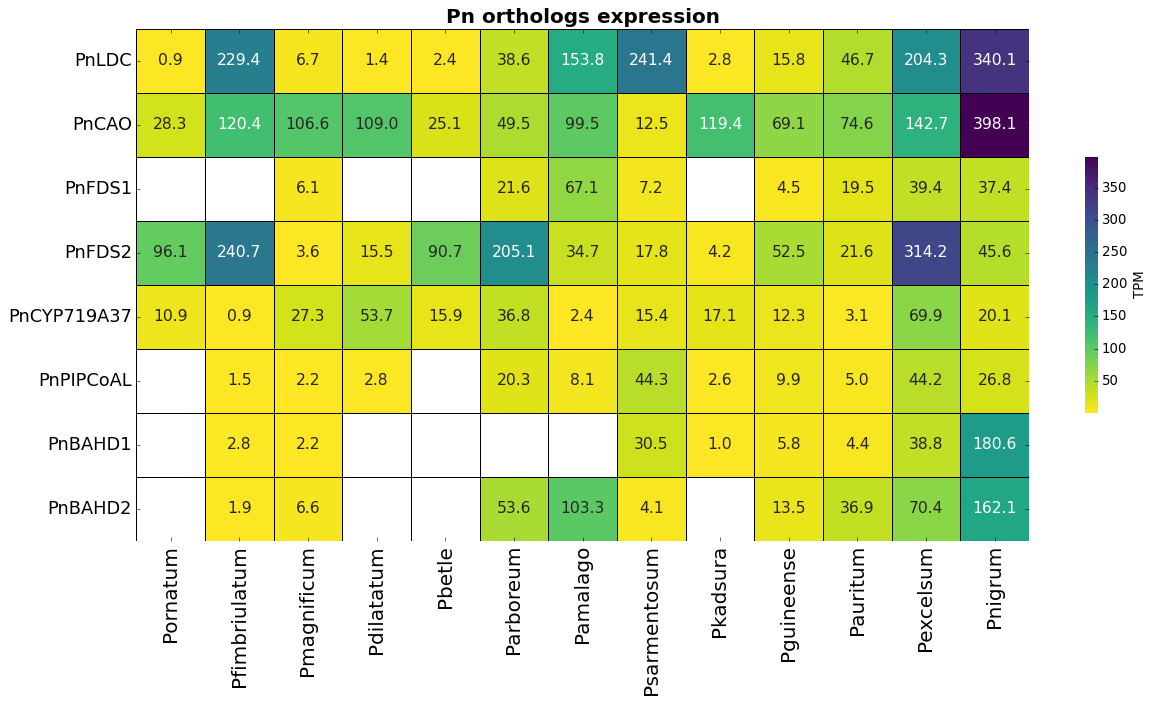

In [30]:
data = pn_orths_expr

#plot heatmap
plt.figure(figsize=(18, 8)) 
sns.heatmap(data, cmap='viridis_r', annot=True, fmt='.1f', annot_kws={"fontsize":14}, #, vmin=2, vmax=50
            linewidths=0.75, linecolor='black',
            cbar_kws={'label': 'TPM', 'orientation': 'vertical', 'pad': 0.05, 'shrink': 0.5})
plt.title('Pn orthologs expression', fontdict={'fontsize': 18, 'fontweight': 'bold'})
plt.yticks(fontsize=16)
plt.xticks(fontsize=18, rotation=90)
plt.xlabel('')
plt.ylabel('')
plt.show()

In [92]:
t = pn_orths['piper56'].apply(lambda x: [query_map[i] for i in x if i in query_map])
t

group_id
3519           [PnLDC]
7882     [PnCYP719A37]
15945          [PnCAO]
19141         [PnFDS2]
26148      [PnPIPCoAL]
26188        [PnBAHD2]
37395        [PnBAHD1]
38523         [PnFDS1]
Name: piper56, dtype: object

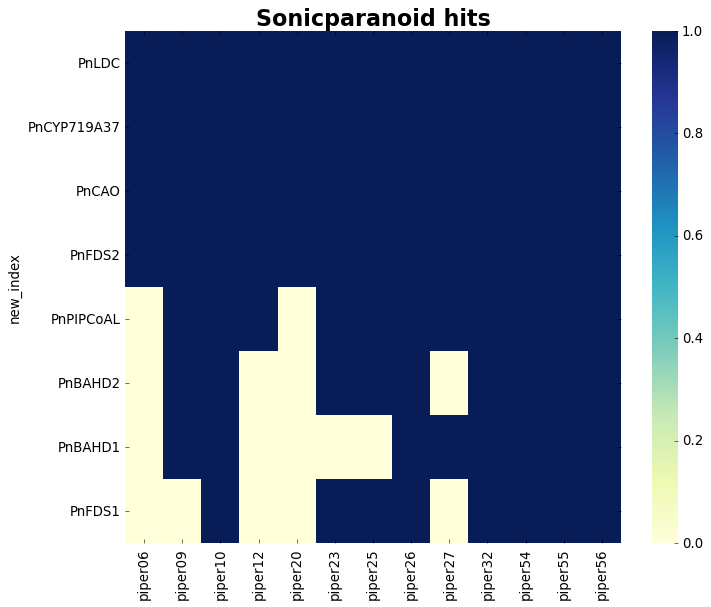

In [67]:
# Use the mapping to set the index in pn_orths
query_map = hits_p56.reset_index().set_index('hit')['query']


pn_orths = sonicpd[sonicpd['piper56'].apply(lambda x: any(i in hits_p56.values for i in x))].copy()
pn_orths['new_index'] = pn_orths['piper56'].apply(lambda x: [query_map[i] for i in x if i in query_map])
pn_orths = pn_orths.explode('new_index').reset_index(drop=True).set_index('new_index')

pn_orths = pn_orths[[col for col in pn_orths.columns if 'piper' in col]]
pn_orths

#replace entries with list lenght
pn_orths = pn_orths.applymap(lambda x: len(x))


#replace entries with presence/absence
pn_orths = pn_orths.applymap(lambda x: 1 if x > 0 else 0)
pn_orths

#display pn_orths as heatmap
plt.figure(figsize=(10, 8))  # adjust the size of the plot as needed
sns.heatmap(pn_orths.astype(float), cmap='YlGnBu')
plt.title('Sonicparanoid hits', fontsize=20, fontweight='bold')
plt.show()

In [ ]:
## Count-based heatmap




#count orthologs per sample
pks_orths_count= pks_orths[sample_cols].applymap(len) 
pks_orths_count = pks_orths_count.rename(columns=species_names) #use species names
pks_orths_count = pks_orths_count.replace(0, np.nan) #replace 0 with NaN
print(f'Total N° of PKS candidates in orthologs: {pks_orths_count.sum().sum().astype(int)}')

### Expression-based heatmap
tpm = proteomes_all.loc[:, [col for col in proteome.columns if 'rep' in col]] #keep TPM columns

#function to assign expression value to orthogroup_table (max or mean TPM)
def assign_orth_expr(orthologs, metric='max'):
    '''
    Assign expression value to each entry in the orthogroup table. Expression values are retrieved from proteomes_all dataframe (max or mean TPM of individual genes)
    '''
    if metric == 'max':
        expr = tpm.loc[orthologs].max().max()
    elif metric == 'mean':
        expr = tpm.loc[orthologs].mean().mean()
    else:
        raise ValueError("Invalid metric. Expected 'max' or 'mean'.")
    return expr

pks_orths_expr = pks_orths[sample_cols].applymap(lambda x: assign_orth_expr(x, 'mean'))#.fillna(0) #apply funct to each entry in pks_orths
pks_orths_expr = pks_orths_expr.rename(columns=species_names) #use species names


### Assign annotation to orthogruops based on blast hits
blast_hits = pd.read_csv('results/blast/pks_hits.csv') #retrieve PKS BLAST results
top_hits = blast_hits.groupby('hit', as_index=False).apply(lambda x: x.sort_values('similarity', ascending=False).head(1)).reset_index(drop=True) #keep only top hit per query per sample

def assign_orth_annotation(orthologs):
    annotation = top_hits[top_hits['hit'].isin(orthologs)]
    return annotation['query'].values

orths_annot = pks_orths[sample_cols].applymap(lambda x: assign_orth_annotation(x))
orths_annot = orths_annot.apply(lambda row: list(set(itertools.chain(*row))), axis=1)


### Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))

#count-based heatmap
sns.heatmap(pks_orths_count, annot=True, cmap='viridis', ax=axes[0])
axes[0].set_title('PKS Orthologs (Count)', fontdict={'fontsize': 24, 'fontweight': 'bold'})
axes[0].tick_params(axis='x', labelsize=20)  # Increase x-axis label size
axes[0].set_yticklabels(orths_annot.tolist(), fontsize=14) # Increase y-axis label size (orthologs names

#expr-based heatmap
sns.heatmap(pks_orths_expr, annot=True, cmap='viridis', vmin=2, vmax=50, ax=axes[1])
axes[1].set_title('PKS Orthologs (Expression)', fontdict={'fontsize': 24, 'fontweight': 'bold'})
axes[1].tick_params(axis='x', labelsize=20)  # Increase x-axis label size

#display plots
plt.tight_layout()
plt.show()

# FROM HERE
- Use entry size to display another parameter

/var/folders/fg/6v3nzv110nxg13st7w34pqvr0000gn/T/ipykernel_13844/2522288137.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, rotation=90)


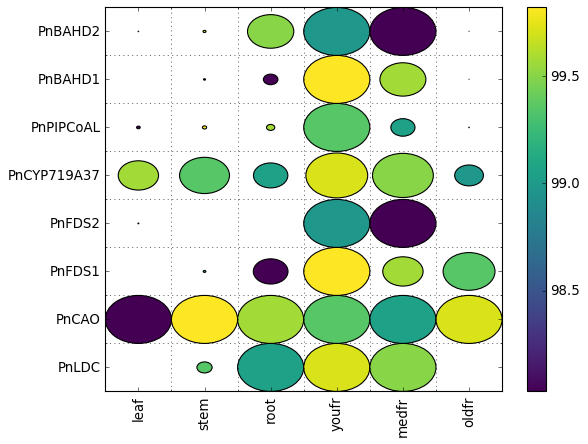

In [85]:
from matplotlib.collections import PatchCollection

s = data
s = s.clip(0, 20)

N = s.shape[0] #number of rows
M = s.shape[1] #number of columns
ylabels = s.index #row labels
xlabels = s.columns #column labels
s = s.to_numpy()
c = sim.to_numpy() #colors

x, y = np.meshgrid(np.arange(M), np.arange(N)) #creates 2D grid of coordinates for the circles


#plot
fig, ax = plt.subplots()
R = s/s.max()/2 #circle radius as half of the value in s divided by the maximum value in s.
circles = [plt.Circle((xcoor,ycoor), radius=r) for xcoor, ycoor, r in zip(x.flat, y.flat, R.flat)] #create a list of Circle patches, one for each element in s.
col = PatchCollection(circles, array=c.flatten(), cmap="viridis")
ax.add_collection(col)

#labls and titles
ax.set_xticklabels(xlabels, rotation=90)
ax.set(xticks=np.arange(M), yticks=np.arange(N),
       xticklabels=xlabels, yticklabels=ylabels)
ax.set_xticks(np.arange(M+1)-0.5, minor=True)
ax.set_yticks(np.arange(N+1)-0.5, minor=True)
ax.grid(which='minor')

fig.colorbar(col)
plt.show()

# DSICARD CODE BELOW AFTER DONE ABOVE

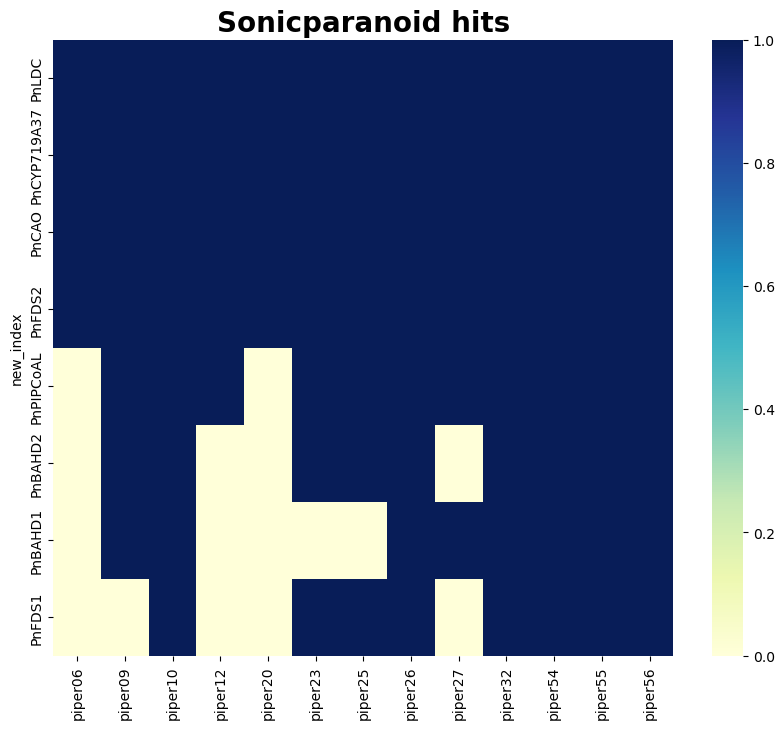

In [99]:
#piper56 best  hit per query
hits_p56 = hits_all[hits_all['sample'] == 'piper56'].sort_values(by='similarity', ascending=False).groupby('query').first()
hits_p56 = hits_p56['hit']

#Filter rows in sonicpd where any element in 'piper56' column is in hits_p56['hit'].values
filtered_sonicpd = sonicpd[sonicpd['piper56'].apply(lambda x: any(i in hits_p56.values for i in x))].copy()

# Create a mapping from the values in hits_p56 to their index
index_mapping = hits_p56.reset_index().set_index('hit')['query']

# Use the mapping to set the index in filtered_sonicpd
filtered_sonicpd['new_index'] = filtered_sonicpd['piper56'].apply(lambda x: [index_mapping[i] for i in x if i in index_mapping])
filtered_sonicpd = filtered_sonicpd.explode('new_index').reset_index(drop=True).set_index('new_index')

filtered_sonicpd = filtered_sonicpd[[col for col in filtered_sonicpd.columns if 'piper' in col]]
filtered_sonicpd

#replace entries with list lenght
filtered_sonicpd = filtered_sonicpd.applymap(lambda x: len(x))


#replace entries with presence/absence
filtered_sonicpd = filtered_sonicpd.applymap(lambda x: 1 if x > 0 else 0)
filtered_sonicpd

#display filtered_sonicpd as heatmap
plt.figure(figsize=(10, 8))  # adjust the size of the plot as needed
sns.heatmap(filtered_sonicpd.astype(float), cmap='YlGnBu')
plt.title('Sonicparanoid hits', fontsize=20, fontweight='bold')
plt.show()